In [1]:
import numpy as np
from matplotlib import pyplot as plt

import loki
from loki.libloki.configs import PulsarSearchConfig
from loki.libloki.ffa import FFAPlan
from loki.libloki.prune import PruningManager
from pyloki.config import ParamLimits
from pyloki.core.taylor import generate_branching_pattern
from pyloki.detection import thresholding
from pyloki.ffa import DynamicProgramming
from pyloki.periodogram import PruningStatsPlotter, ScatteredPeriodogram
from pyloki.prune import prune_dyp_tree
from pyloki.simulation.pulse import PulseSignalConfig

tobs = 2147.483648


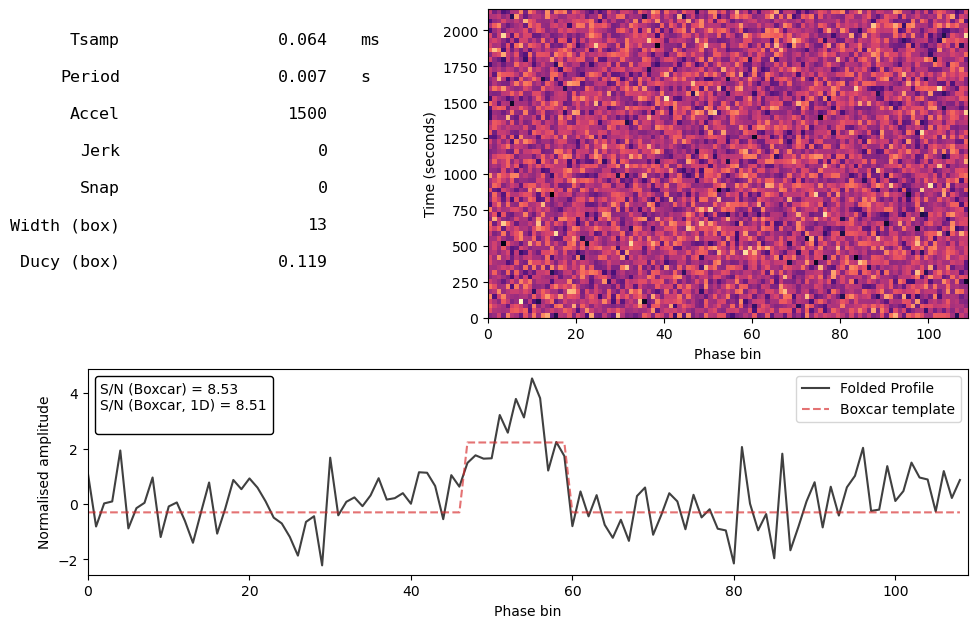

In [2]:
pulsar_period = 0.007
dt = 64e-6
accel = 1500         
nsamps = 2**25
mod_kwargs = {"acc": accel}
cfg = PulseSignalConfig(period=pulsar_period, dt=dt, nsamps=nsamps, snr=8.5, ducy=0.1, mod_kwargs=mod_kwargs)
print(f"tobs = {cfg.tobs}")
tim_data = cfg.generate(shape="gaussian")
tim_data.plot_fold(cfg.freq, cfg.fold_bins, mod_kwargs=mod_kwargs)
plt.show()

In [3]:
tol_bins = 1 
fold_bins = 64
p = ParamLimits.from_taylor((140.0, 145.0), (-2500.0, 2500.0) )
print(f"Param limits: {p.limits}")
bseg_brute = cfg.nsamps // 16384
bseg_ffa = cfg.nsamps // 128
search_cfg = PulsarSearchConfig(nsamps=cfg.nsamps, tsamp=cfg.dt, nbins=fold_bins, tol_bins=tol_bins, param_limits=p.limits,
                                bseg_brute=bseg_brute, bseg_ffa=bseg_ffa, prune_poly_order=2, nthreads=8, ducy_max=0.2, wtsp=1.1,
                                use_fft_shifts=True)
plan = FFAPlan(search_cfg)
branching_pattern = plan.generate_branching_pattern()
branching_pattern

Param limits: [(-2500.0, 2500.0), (140.0, 145.0)]


array([8.        , 3.        , 2.        , 3.        , 1.        ,
       1.        , 2.        , 3.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 2.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 3.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       2.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 3.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 2.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

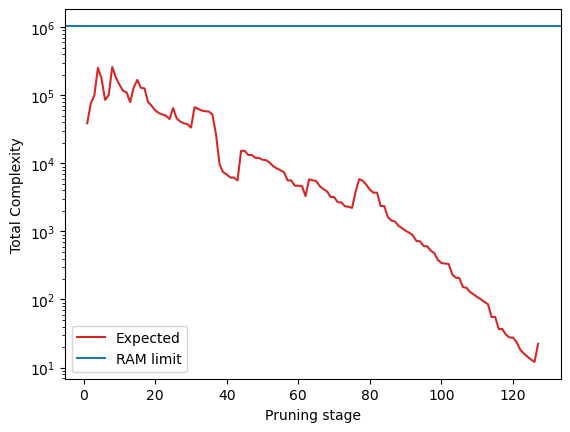

In [4]:
thresholds = np.array([2.1, 2.5, 2.6, 2.5, 2.7, 3. , 3.1, 2.9, 3.1, 3.1, 3.1, 2.9, 3.2,
       3.5, 3.6, 3.6, 3.2, 3.7, 3.6, 3.6, 3.5, 3.4, 3.3, 3.4, 3.9, 4. ,
       3.9, 3.8, 3.7, 3.8, 3.5, 3.6, 3.6, 3.5, 3.4, 3.6, 4.1, 4.5, 4.5,
       4.4, 4.4, 4. , 4.3, 4.3, 4. , 4.3, 4. , 4.2, 4. , 4.1, 4. , 4.1,
       4.2, 4.2, 4.2, 4.2, 4.4, 4. , 4.4, 4.2, 4.1, 4.5, 4.5, 4.4, 4.3,
       4.5, 4.5, 4.5, 4.6, 4.4, 4.6, 4.4, 4.6, 4.5, 4.5, 4.6, 4.4, 4.5,
       4.6, 4.7, 4.7, 4.4, 4.9, 4.5, 5. , 5. , 4.9, 5. , 5. , 5. , 5. ,
       5. , 5.1, 4.9, 5.1, 4.9, 5.1, 5.1, 5.2, 5.2, 5.1, 5. , 5.3, 5.3,
       5.2, 5.4, 5.3, 5.4, 5.4, 5.4, 5.4, 5.4, 5.4, 5.6, 5.3, 5.7, 5.3,
       5.7, 5.7, 5.3, 5.7, 5.8, 5.8, 5.8, 5.8, 5.8, 5.8])
thresh_state = thresholding.evaluate_scheme(thresholds, branching_pattern, ref_ducy=0.1, nbins=64,
                                            ntrials=1024, snr_final=8.5, ducy_max=0.2, wtsp=1.5)
x = np.arange(1, len(branching_pattern) + 1)
nparam_vol = plan.ncoords[-1]
plt.semilogy(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Expected", c="tab:red")
plt.axhline(2**20, label="RAM limit", c="tab:blue")
plt.xlabel("Pruning stage")
plt.ylabel("Total Complexity")
plt.legend()
plt.show()

In [5]:
with loki.libloki.ostream_redirect(stdout=True, stderr=True):
    prn_manager = PruningManager(search_cfg, thresholds, n_runs=32, max_sugg=2**20, batch_size=1024)
    prn_manager.execute(tim_data.ts_e, tim_data.ts_v, outdir="pruning_results/accel_test/", file_prefix="test_accel", kind="taylor", show_progress=False)

[2025-08-20 00:14:54.791] [info] PruningManager: Initializing with FFA
[2025-08-20 00:14:54.850] [info] FFACOMPLEX Memory Usage: 0.34 GB (1 buffers) + 0.00 GB (coords)
[2025-08-20 00:14:54.878] [info] FFACOMPLEX::execute started
[2025-08-20 00:14:54.878] [info] FFACOMPLEX::initialize started
[2025-08-20 00:14:56.010] [info] FFACOMPLEX::initialize took 1132 ms
[2025-08-20 00:14:56.064] [info] FFACOMPLEX::execute took 1186 ms
[2025-08-20 00:14:56.070] [info] Starting Pruning for 32 runs, with 8 threads
[2025-08-20 00:14:56.599] [info] Pruning run 016: Memory Usage: 0.58 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 00:14:56.599] [info] Pruning run 016: initialized
[2025-08-20 00:14:56.610] [info] Pruning run 029: Memory Usage: 0.58 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 00:14:56.610] [info] Pruning run 029: initialized
[2025-08-20 00:14:56.619] [info] Pruning run 020: Memory Usage: 0.58 GB (suggestions) + 0.01 GB (workspace)
[2025-08-20 00:14:56.619] [info] Pruning run 0

In [6]:
result_file = "pruning_results/accel_test/test_accel_pruning_nstages_128_results.h5"
pgram = ScatteredPeriodogram.load(result_file)
print(f"True params, a: {cfg.mod_kwargs["acc"]:.3f}, f: {cfg.freq:.10f}")
print(pgram.get_summary_cands(10, run_id=None))

True params, a: 1500.000, f: 142.8571428571
Top candidates:
dparams: daccel: 0.2099153238, dfreq: 2.299561913e-05
Run: 037_10, S/N: 9.21, accel: 1496.77, freq: 142.857145
Run: 041_11, S/N: 8.71, accel: 1497.19, freq: 142.857151
Run: 123_31, S/N: 8.70, accel: 1507.90, freq: 142.857179
Run: 123_31, S/N: 8.65, accel: 1507.90, freq: 142.857202
Run: 037_10, S/N: 8.64, accel: 1496.77, freq: 142.857168
Run: 041_11, S/N: 8.49, accel: 1497.40, freq: 142.857159
Run: 123_31, S/N: 8.41, accel: 1507.90, freq: 142.857156
Run: 045_12, S/N: 8.34, accel: 1497.82, freq: 142.857143
Run: 041_11, S/N: 8.33, accel: 1497.19, freq: 142.857128
Run: 119_30, S/N: 8.26, accel: 1507.27, freq: 142.857173


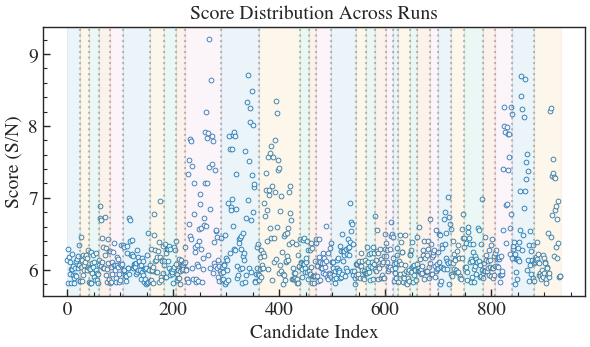

In [7]:
pgram.plot_scores(kind="scatter", run_id=None)
plt.show()

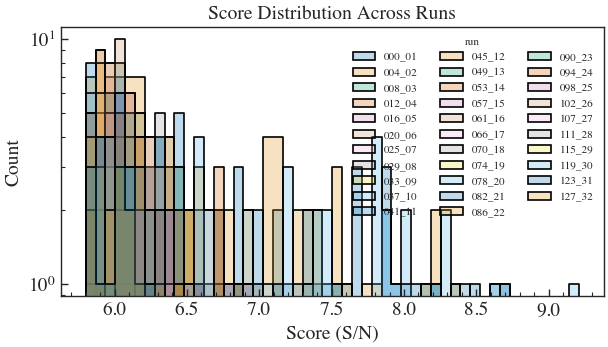

In [8]:
pgram.plot_scores(kind="hist", run_id=None)
plt.show()

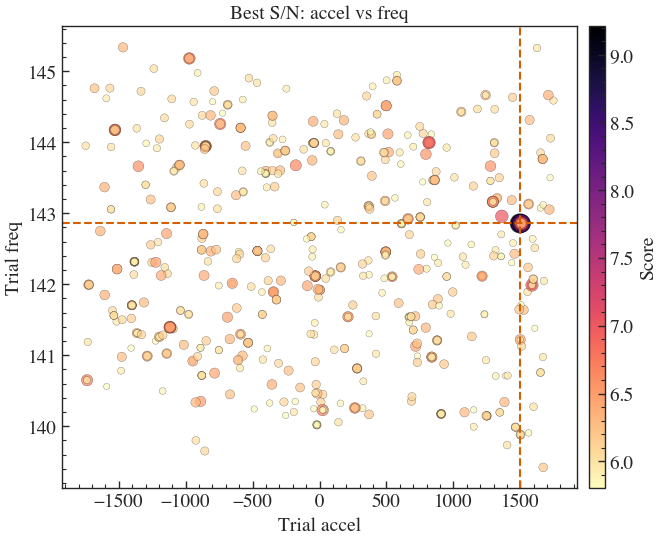

In [9]:
pgram.plot_correlation("accel", "freq", true_values={"accel": cfg.mod_kwargs["acc"], "freq": cfg.freq}, run_id=None)
plt.show()

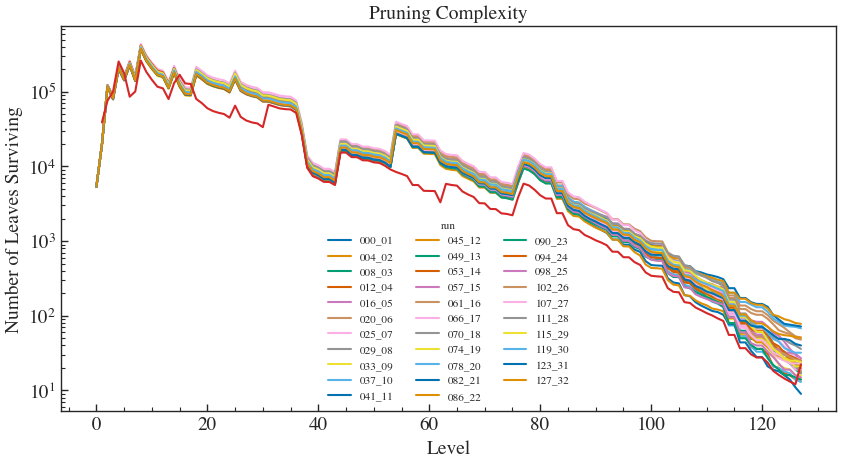

In [10]:
pstats = PruningStatsPlotter.load(result_file)
fig = pstats.plot_level_stats(run_id=None)
x = np.arange(1, len(branching_pattern) + 1)
ax_list = fig.axes
ax_list[0].plot(x, np.array(thresh_state.get_info("complexity")) * nparam_vol, label="Expected", c="tab:red")
plt.show()